**Road Segmentation**

Using camvid dataset for road segmentation.



In [36]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

import tensorflow as tf
from tensorflow import keras

#from tf_seg.data import DataLoader
from tf_seg.data import get_data_loader,get_camvid_data_loader
from tf_seg.models import Unet
from tf_seg.losses import FocalTverskyLoss
from tf_seg.metrics import DiceScore
from tf_seg.transformers import Transformer
#from tf_seg.utils import AlbumentatiosWrapper


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config mananagment can be two ways: 
- First, you can use python dict object to configure the data,model etc.
- Second, you can use a config file as yaml format. if you use this way, you must ```get_config``` function to get the config file and check if it is valid.


In [1]:
# camvid data config

data_config = dict(
    name = "road_segmentation",
    function_name = "camvid", # it is used camvid dataset to generate binary data
    path="../dataset/camvid",
    classes=["Road"],
    normalizing=True,
    palette=[(128, 64, 128)],
    one_hot_encoding=True,  # target output shape
    background_adding=False,  # add target background class
    image_size=(256, 256),
    batch_size=16,
    #output_type=("tf.float32", "tf.float32"),  # this is for camvid data types after data processing
    channels=(3, 3),  # it is optional
)

model_config = dict(
    #n_filters=[16, 32, 64, 128, 256],
    n_filters=[4, 8, 16, 32, 64],
    input_shape=[data_config["image_size"][0], data_config["image_size"][1],3],
    final_activation="sigmoid",
    activation="relu",
    backbone=None ,#"ResNet50",
    pretrained="imagenet",
    output_size= 1
)

aug_config = dict(
    aug_type="albumentations",
)

# epochs = 10


In [ ]:
#get_camvid_data_loader(data_config, train_data=True, val_data=True, test_data=False)
# get_data_loader(data_config, train_data=True, val_data=True, test_data=False) #or, this is a selection function

#### DataLoader

This function is support function getting a DataLoader object that is loading data from disk as tensorflow dataset. There are many special data loader functions for different dataset. Also, there is a custom data loader function for custom datasets.



In [4]:
# there are three parts as train, val, test in camvid dataset
train_data_loader,val_data_loader,test_data_loader = get_camvid_data_loader(data_config)
#train_data_loader.load_data? # show docstring

2022-09-05 16:47:09.900644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/omr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-05 16:47:09.900727: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-05 16:47:09.900766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (omr): /proc/driver/nvidia/version does not exist
2022-09-05 16:47:09.901319: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# generate dataset from data_loader object via load_data function
train_dataset = train_data_loader.load_data()
val_dataset = val_data_loader.load_data()
test_dataset = test_data_loader.load_data()

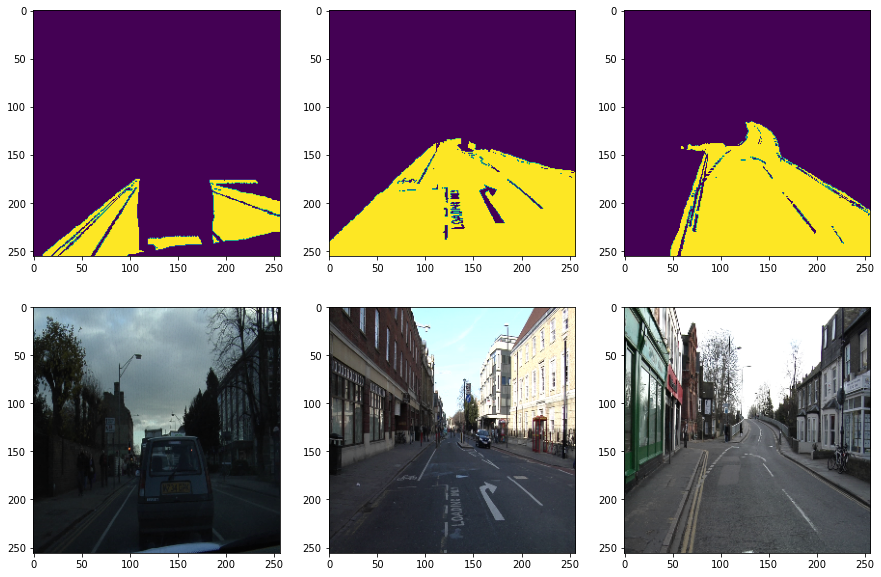

In [6]:
def show_data(train_dataset=None,val_dataset=None,test_dataset=None):
    "support function to show data"

    plt.figure(figsize=(15, 10))
    if train_dataset:
        for i,m in train_dataset.take(1):
            plt.subplot(2,3,1)
            plt.imshow(m[0])
            plt.subplot(2,3,4)
            plt.imshow(i[0].numpy().astype(int))
    if val_dataset:
        for i,m in val_dataset.take(1):
            plt.subplot(2,3,2)
            plt.imshow(m[0])
            plt.subplot(2,3,5)
            plt.imshow(i[0].numpy().astype(int))
    if test_dataset:
        for i,m in test_dataset.take(1):
            plt.subplot(2,3,3)
            plt.imshow(m[0])
            plt.subplot(2,3,6)
            plt.imshow(i[0].numpy().astype(int))

show_data(train_dataset,val_dataset,test_dataset)

**With augmentation function**

In [7]:
IM_SIZE = data_config["image_size"][0]


train_transforms = A.Compose(
    [
        A.Resize(IM_SIZE, IM_SIZE),
        A.OneOf([
            A.RandomSizedCrop(min_max_height=(256, 256), height=IM_SIZE, width=IM_SIZE, p=0.5),
            A.CenterCrop(height=IM_SIZE, width=IM_SIZE, p=0.5),
            A.PadIfNeeded(min_height=IM_SIZE, min_width=IM_SIZE, p=0.5)
            ], p=1),
        A.OneOf([
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5)]),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)
            ], p=0.8),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(IM_SIZE, IM_SIZE),
      
    ]
)



```Transformer``` is a class to use albumentations fucntions or other augmentation packages with tf.data.Dataset.map function effectively.



In [70]:
tr_transforms_object= Transformer(aug_config,"train",train_transforms)
ts_transforms_object = Transformer(aug_config,"test",test_transforms)

# get datasets with augmentation

train_dataset = train_data_loader.load_data(transform_func=tr_transforms_object)
val_dataset = val_data_loader.load_data(transform_func=ts_transforms_object)
test_dataset = test_data_loader.load_data(transform_func=ts_transforms_object)

2022-09-05 17:10:23.307540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


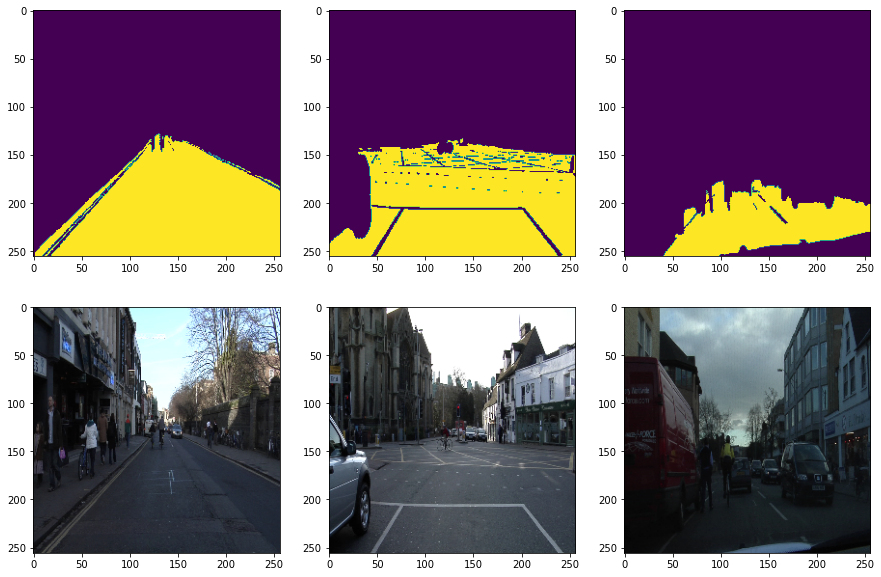

In [69]:
show_data(train_dataset,val_dataset,test_dataset)

#### Make Model

In [ ]:
print(model_config)
       

In [ ]:
model = Unet(**model_config).build_model()
model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=FocalTverskyLoss(alpha=0.5, gamma=0.5), metrics=[DiceScore()])

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model_history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)